In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from random import randrange
import seaborn as sns
sns.set()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('Iris.csv')
Y = df.iloc[:,-1].values
df = df.iloc[:,1:-1]
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
def PCA(X, dimensions = 2):
    X = X - np.tile(np.mean(X, 0), (X.shape[0], 1))
    _, eigenvectors = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, eigenvectors[:, :dimensions])
    return Y

In [4]:
labels = np.unique(Y)
X = PCA(df.values)
Y = LabelEncoder().fit_transform(Y)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.2)

In [5]:
def divide(X, i, threshold):
    more_than = np.where(X[:,i]>=threshold)[0]
    less_than = np.setxor1d(np.arange(X.shape[0]), more_than)
    return np.array([X[more_than,:], X[less_than,:]])

class Node:
    def __init__(self, feature=None, threshold=None, val=None, true_b=None, false_b=None):
        self.feature = feature
        self.threshold = threshold
        self.val = val
        self.true_b = true_b
        self.false_b = false_b
        
class RegressionTree:
    def __init__(self, min_samples_split=2, min_impurity = 1e-8, max_depth=float('inf')):
        self.root = None
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.impurity_calculation = None
        self.leaf_value_calculation = None
        
    def _cal_variance_reduction(self, Y, y_more, y_less):
        var = np.var(Y)
        var_more = np.var(y_more)
        var_less = np.var(y_less)
        frac_more = len(y_more) / len(Y)
        frac_less = len(y_less) / len(Y)
        return np.sum(var - (frac_more * var_more + frac_less * var_less))
    
    def _mean_y(self, Y):
        val = np.mean(Y,axis=0)
        return val if len(val) > 1 else val[0]
        
    def build_tree(self, X, Y, current_depth=0):
        largest_impurity = 0
        best_criteria = None
        best_sets = None
        if len(Y.shape) == 1:
            Y = np.expand_dims(Y, axis=1)
        XY = np.concatenate((X, Y), axis=1)
        n_samples, n_features = np.shape(X)
        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            for i in range(n_features):
                feature_values = np.expand_dims(X[:, i], axis=1)
                unique_values = np.unique(feature_values)
                for threshold in unique_values:
                    XY_more, XY_less = divide(XY, i, threshold)
                    if XY_more.shape[0] > 0 and XY_less.shape[0]:
                        y_more = XY_more[:, n_features:]
                        y_less = XY_less[:, n_features:]
                        impurity = self._cal_variance_reduction(Y, y_more, y_less)
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"i": i, "threshold": threshold}
                            best_sets = {
                                'left_X': XY_more[:, :n_features],
                                'left_Y': XY_more[:, n_features:],
                                'right_X': XY_less[:, :n_features],
                                'right_Y': XY_less[:, n_features:],
                            }
        if largest_impurity > self.min_impurity:
            T_branch = self.build_tree(best_sets["left_X"], best_sets["left_Y"], current_depth + 1)
            F_branch = self.build_tree(best_sets["right_X"], best_sets["right_Y"], current_depth + 1)
            return Node(feature=best_criteria['i'],threshold=best_criteria['threshold'],
                       true_b=T_branch, false_b=F_branch)
        selected_val = self._mean_y(Y)
        return Node(val=selected_val)
    
    def fit(self, X, Y):
        self.root = self.build_tree(X, Y)
        
    def _predict_val(self, X, tree=None):
        if tree is None:
            tree = self.root
        if tree.val is not None:
            return tree.val
        feature_val = X[tree.feature]
        branch = tree.false_b
        if feature_val >= tree.threshold:
            branch = tree.true_b
        return self._predict_val(X, branch)
    
    def predict(self, X):
        results = []
        for i in range(X.shape[0]):
            results.append(self._predict_val(X[i,:]))
        return results  

In [6]:
def subsample(X, Y, ratio=0.6):
    sample, label = [], []
    n_sample = round(len(X) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(X))
        sample.append(X[index])
        label.append(Y[index])
    return np.array(sample), np.array(label)

In [7]:
class Bagging_Classifier:
    def __init__(self, n_estimators=10, learning_rate=0.1, 
                 min_samples_split=2, min_impurity=1e-8, max_depth=float('inf')):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.trees = []
        for i in range(self.n_estimators):
            tree = RegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth)
            self.trees.append(tree)
            
    def fit(self, X, Y):
        for i in range(self.n_estimators):
            sample_X, sample_Y = subsample(X, Y)
            self.trees[i].fit(sample_X, sample_Y)
    
    def predict(self, X, prob=False):
        y_pred = np.zeros((X.shape[0]))
        for tree in self.trees:
            y_pred += np.array(tree.predict(X))
        y_pred /= len(self.trees)
        return y_pred

In [8]:
bagging = Bagging_Classifier(n_estimators=200)
bagging.fit(train_X, train_Y)

In [14]:
acc = np.mean(np.around(bagging.predict(test_X)) == test_Y)
acc

0.93333333333333335

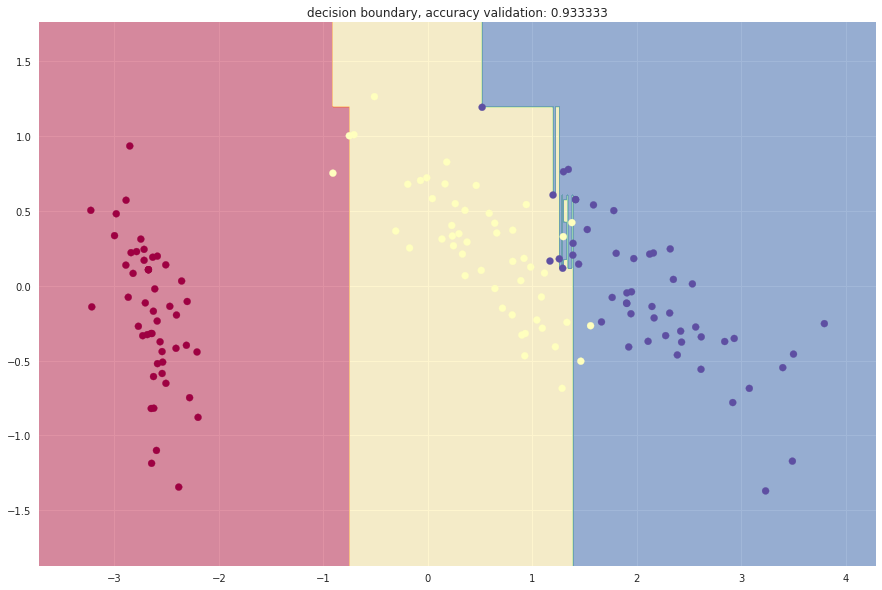

In [15]:
plt.figure(figsize=(15, 10))
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = np.around(bagging.predict(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha = 0.5)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
plt.title('decision boundary, accuracy validation: %f'%(acc))
plt.show()